Disciplina: Aprendizagem de Máquina Probabilística

Período: 2025.2

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 6 - Autoencoder and Variational Autoencoder

Questão 1 - Treine um modelo Autoencoder (AE) e um modelo Variational Autoencoder (VAE) a partir do dataset FashionMNIST (https://github.com/zalandoresearch/fashion-mnist). Use a partição de teste como conjunto de validação, não a incluindo no treinamento dos modelos. Use os códigos e
dados fornecidos.

Note que há trechos de código omitidos que devem ser completados (procure por “COMPLETE AQUI!”): função encode do VAE; plot functions (ao final do notebook).
Em seguida:

- Mostre a projeção no espaço latente obtida para os dados de treino em ambos os modelos. No caso do modelo VAE, projete uma amostra da distribuição projetada. Qual a diferença entre as duas projeções?
- Gere múltiplas novas imagens, amostrando de N (0, I) e usando o decodificador de ambos os modelos treinados. Qual a diferença entre as amostras obtidas?

Questão 2 - Modifique os modelos da questão anterior tornando-os condicionais à classe da imagem. Para tanto, execute as 2 modificações a seguir:
- Concatene à entrada do codificador o rótulo da imagem.
- Concatene à entrada do decodificador o rótulo da imagem.
Note que o rótulo deve ser codificado em one-hot-encoding.

Em seguida:
- Mostre a projeção no espaço latente obtida para os dados de treino em ambos os modelos. O que diferiu das projeções da questão anterior?
- Gere múltiplas novas imagens, amostrando de N (0, I) e usando o decodificador de ambos os modelos treinados, condicionados a diferentes valores de rótulos (entre 1 e 10). O que diferiu das imagens geradas na questão anterior?


# Variational Autoencoder

## Data preparation

In [2]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

torch.manual_seed(123)

batch_size = 512
learning_rate = 5*1e-3
num_epochs = 50
latent_dim = 2
hidden_dim = [512, 256]

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1)),
])

train_data = datasets.FashionMNIST('FashionMNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('FashionMNIST_data/', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

for X, _ in train_loader:
    input_dim = X.shape[1]
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    break

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

100%|██████████| 26.4M/26.4M [00:12<00:00, 2.14MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.43MB/s]


Shape of X [N, C, H, W]: torch.Size([512, 784])
Using device: cpu


## Autoencoder definition

In [3]:
@dataclass
class AEOutput:
    """
    Dataclass for AE output.
    """
    z_proj: torch.Tensor
    x_recon: torch.Tensor
    loss: torch.Tensor

class AE(nn.Module):
    """
    Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(AE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        encoder_layers_list = []
        if type(hidden_dim) != list:
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim))
            encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim, 2 * latent_dim))
        else:
            self.hidden_dim = hidden_dim.copy()
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim[0]))
            encoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim[1:])):
                encoder_layers_list.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim[-1], latent_dim))

        self.encoder = nn.Sequential(*encoder_layers_list)

        decoder_layers_list = []
        if type(hidden_dim) != list:
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim))
            decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim, input_dim))
            decoder_layers_list.append(nn.Sigmoid())
        else:
            hidden_dim_decoder = hidden_dim[::-1]
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim_decoder[0]))
            decoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim_decoder[1:])):
                decoder_layers_list.append(nn.Linear(hidden_dim_decoder[i], hidden_dim_decoder[i+1]))
                decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim_decoder[-1], input_dim))
            decoder_layers_list.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers_list)

        print(f"Encoder: {encoder_layers_list}")
        print(f"Decoder: {decoder_layers_list}")

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, compute_loss: bool = True):
        z_proj = self.encode(x)
        recon_x = self.decode(z_proj)

        if not compute_loss:
            return AEOutput(
                z_proj=z_proj,
                x_recon=recon_x,
                loss=None,
            )

        loss = F.binary_cross_entropy(recon_x, x, reduction='none').sum(-1).mean()

        return AEOutput(
                z_proj=z_proj,
                x_recon=recon_x,
                loss=loss,
            )

## Variational Autoencoder definition

In [9]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        encoder_layers_list = []
        if type(hidden_dim) != list:
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim))
            encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim, 2 * latent_dim))
        else:
            self.hidden_dim = hidden_dim.copy()
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim[0]))
            encoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim[1:])):
                encoder_layers_list.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim[-1], 2 * latent_dim))

        self.encoder = nn.Sequential(*encoder_layers_list)
        self.softplus = nn.Softplus()

        decoder_layers_list = []
        if type(hidden_dim) != list:
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim))
            decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim, input_dim))
            decoder_layers_list.append(nn.Sigmoid())
        else:
            hidden_dim_decoder = hidden_dim[::-1]
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim_decoder[0]))
            decoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim_decoder[1:])):
                decoder_layers_list.append(nn.Linear(hidden_dim_decoder[i], hidden_dim_decoder[i+1]))
                decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim_decoder[-1], input_dim))
            decoder_layers_list.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers_list)

        print(f"Encoder: {encoder_layers_list}")
        print(f"Decoder: {decoder_layers_list}")

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """

        """
            COMPLETE AQUI!

            Codifique a entrada em uma distribuição variacional Gaussiana.
            Lembre que o codificador retorna as médias e os logs das variâncias.
            Você pode usar eps para evitar uma variância excessivamente pequena.
            Você deve retornar um objeto torch.distributions.MultivariateNormal.

            COMPLETE AQUI!
        """

        h = self.encoder(x)

        # Separa média e log-variância
        mu, logvar = torch.chunk(h, 2, dim=-1)

        # converte log-variância em desvio padrão positivo
        std = self.softplus(logvar) + eps

        # matriz diagonal de Cholesky (scale_tril)
        scale_tril = torch.diag_embed(std)

        # Distribuição Guassiana multivariada
        return torch.distributions.MultivariateNormal(loc=mu, scale_tril=scale_tril)


    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """

        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )

        # compute loss terms
        loss_recon = F.binary_cross_entropy(recon_x, x, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

## Train and Test functions

In [10]:
def train(model, dataloader, optimizer, prev_updates):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode

    loss_history = []
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, desc='Training')):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass

        loss = output.loss
        loss.backward()

        optimizer.step()  # Update the model parameters

        loss_history.append(loss.item())

    print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Train set loss: {np.mean(loss_history):.4f}')

    return prev_updates + len(dataloader), loss_history

def test(model, dataloader):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0

    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()

    test_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f}')

    return test_loss

## Train the Autoencoder

In [11]:
print("Training Autoencoder...")
model_AE = AE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
print(model_AE)
optimizer = torch.optim.AdamW(model_AE.parameters(), lr=learning_rate)

train_loss_history_AE = []
test_loss_history_AE = []
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates, train_loss = train(model_AE, train_loader, optimizer, prev_updates)
    test_loss = test(model_AE, test_loader)
    train_loss_history_AE.append(np.mean(train_loss))
    test_loss_history_AE.append(test_loss)

Training Autoencoder...
Encoder: [Linear(in_features=784, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=2, bias=True)]
Decoder: [Linear(in_features=2, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=784, bias=True), Sigmoid()]
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): Leak

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 117 (N samples: 59,904), Train set loss: 295.5256


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 266.6233
Epoch 2/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 235 (N samples: 120,320), Train set loss: 261.7625


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.8940
Epoch 3/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 353 (N samples: 180,736), Train set loss: 257.6333


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.6288
Epoch 4/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 471 (N samples: 241,152), Train set loss: 254.9371


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 255.0815
Epoch 5/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 589 (N samples: 301,568), Train set loss: 253.2036


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 253.9770
Epoch 6/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 707 (N samples: 361,984), Train set loss: 252.5645


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 254.0320
Epoch 7/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 825 (N samples: 422,400), Train set loss: 251.9763


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 254.3840
Epoch 8/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 943 (N samples: 482,816), Train set loss: 251.7299


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 254.3650
Epoch 9/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,061 (N samples: 543,232), Train set loss: 250.8514


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 252.4429
Epoch 10/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,179 (N samples: 603,648), Train set loss: 250.2543


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 252.0540
Epoch 11/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,297 (N samples: 664,064), Train set loss: 250.2170


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 254.9051
Epoch 12/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,415 (N samples: 724,480), Train set loss: 250.0754


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.0725
Epoch 13/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,533 (N samples: 784,896), Train set loss: 248.8180


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.9421
Epoch 14/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,651 (N samples: 845,312), Train set loss: 249.0227


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.7715
Epoch 15/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,769 (N samples: 905,728), Train set loss: 249.0338


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.1581
Epoch 16/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,887 (N samples: 966,144), Train set loss: 248.4015


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.5887
Epoch 17/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,005 (N samples: 1,026,560), Train set loss: 248.7100


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.7106
Epoch 18/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,123 (N samples: 1,086,976), Train set loss: 248.7359


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.3094
Epoch 19/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,241 (N samples: 1,147,392), Train set loss: 248.0806


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.2605
Epoch 20/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,359 (N samples: 1,207,808), Train set loss: 248.3704


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.2347
Epoch 21/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,477 (N samples: 1,268,224), Train set loss: 248.5472


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.1581
Epoch 22/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,595 (N samples: 1,328,640), Train set loss: 247.6568


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.1924
Epoch 23/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,713 (N samples: 1,389,056), Train set loss: 247.4185


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.3411
Epoch 24/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,831 (N samples: 1,449,472), Train set loss: 247.2453


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.2924
Epoch 25/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,949 (N samples: 1,509,888), Train set loss: 247.9778


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.1686
Epoch 26/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,067 (N samples: 1,570,304), Train set loss: 246.5869


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.3917
Epoch 27/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,185 (N samples: 1,630,720), Train set loss: 248.2318


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.1055
Epoch 28/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,303 (N samples: 1,691,136), Train set loss: 246.7872


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 252.0868
Epoch 29/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,421 (N samples: 1,751,552), Train set loss: 247.4557


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.0172
Epoch 30/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,539 (N samples: 1,811,968), Train set loss: 246.4537


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.0551
Epoch 31/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,657 (N samples: 1,872,384), Train set loss: 246.5964


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.1471
Epoch 32/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,775 (N samples: 1,932,800), Train set loss: 246.5958


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.0390
Epoch 33/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,893 (N samples: 1,993,216), Train set loss: 246.4231


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.6199
Epoch 34/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,011 (N samples: 2,053,632), Train set loss: 246.9847


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.4609
Epoch 35/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,129 (N samples: 2,114,048), Train set loss: 246.6127


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.9567
Epoch 36/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,247 (N samples: 2,174,464), Train set loss: 246.1265


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.0716
Epoch 37/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,365 (N samples: 2,234,880), Train set loss: 245.7120


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.9772
Epoch 38/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,483 (N samples: 2,295,296), Train set loss: 245.4414


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.7840
Epoch 39/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,601 (N samples: 2,355,712), Train set loss: 246.3848


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.3853
Epoch 40/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,719 (N samples: 2,416,128), Train set loss: 245.9664


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.0956
Epoch 41/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,837 (N samples: 2,476,544), Train set loss: 245.3396


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.5131
Epoch 42/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,955 (N samples: 2,536,960), Train set loss: 245.2273


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.7929
Epoch 43/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,073 (N samples: 2,597,376), Train set loss: 245.4417


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.5707
Epoch 44/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,191 (N samples: 2,657,792), Train set loss: 245.1312


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.8151
Epoch 45/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,309 (N samples: 2,718,208), Train set loss: 245.3091


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.6525
Epoch 46/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,427 (N samples: 2,778,624), Train set loss: 244.9047


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.6211
Epoch 47/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,545 (N samples: 2,839,040), Train set loss: 245.3312


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.3376
Epoch 48/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,663 (N samples: 2,899,456), Train set loss: 246.1934


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.6610
Epoch 49/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,781 (N samples: 2,959,872), Train set loss: 244.6760


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.8638
Epoch 50/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,899 (N samples: 3,020,288), Train set loss: 244.8565


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.4970


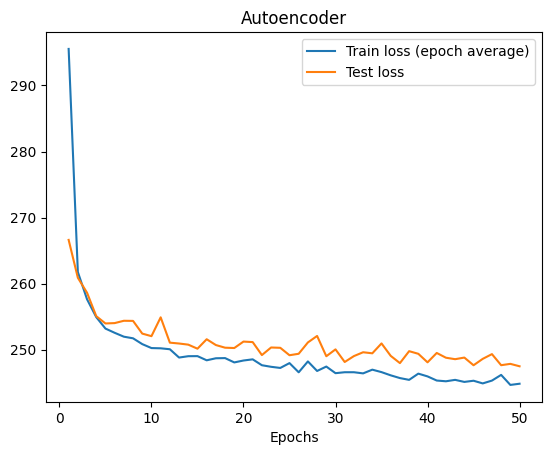

In [12]:
plt.plot(range(1,len(train_loss_history_AE)+1), train_loss_history_AE, label="Train loss (epoch average)")
plt.plot(range(1,len(train_loss_history_AE)+1), test_loss_history_AE, label="Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Autoencoder")
plt.show()

## Train the Variational Autoencoder

In [13]:
print("Training Variational Autoencoder...")
model_VAE = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
print(model_VAE)
optimizer = torch.optim.AdamW(model_VAE.parameters(), lr=learning_rate)

train_loss_history_VAE = []
test_loss_history_VAE = []
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates, train_loss = train(model_VAE, train_loader, optimizer, prev_updates)
    test_loss = test(model_VAE, test_loader)
    train_loss_history_VAE.append(np.mean(train_loss))
    test_loss_history_VAE.append(test_loss)

Training Variational Autoencoder...
Encoder: [Linear(in_features=784, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=4, bias=True)]
Decoder: [Linear(in_features=2, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=784, bias=True), Sigmoid()]
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Line

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 117 (N samples: 59,904), Train set loss: 300.5897


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 274.0852
Epoch 2/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 235 (N samples: 120,320), Train set loss: 268.6548


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 266.7568
Epoch 3/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 353 (N samples: 180,736), Train set loss: 264.6206


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 265.0870
Epoch 4/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 471 (N samples: 241,152), Train set loss: 262.8426


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 265.8548
Epoch 5/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 589 (N samples: 301,568), Train set loss: 261.7400


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 262.8422
Epoch 6/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 707 (N samples: 361,984), Train set loss: 260.4199


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 262.4000
Epoch 7/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 825 (N samples: 422,400), Train set loss: 259.6053


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 262.1232
Epoch 8/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 943 (N samples: 482,816), Train set loss: 259.3326


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 264.3331
Epoch 9/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,061 (N samples: 543,232), Train set loss: 258.8930


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.7846
Epoch 10/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,179 (N samples: 603,648), Train set loss: 258.8518


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.6175
Epoch 11/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,297 (N samples: 664,064), Train set loss: 258.0211


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.2744
Epoch 12/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,415 (N samples: 724,480), Train set loss: 258.1735


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.0058
Epoch 13/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,533 (N samples: 784,896), Train set loss: 257.3276


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.2188
Epoch 14/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,651 (N samples: 845,312), Train set loss: 257.5541


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.6708
Epoch 15/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,769 (N samples: 905,728), Train set loss: 257.2721


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.4789
Epoch 16/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,887 (N samples: 966,144), Train set loss: 256.7124


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.9308
Epoch 17/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,005 (N samples: 1,026,560), Train set loss: 256.3807


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.4256
Epoch 18/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,123 (N samples: 1,086,976), Train set loss: 256.8954


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.6437
Epoch 19/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,241 (N samples: 1,147,392), Train set loss: 256.4804


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.2338
Epoch 20/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,359 (N samples: 1,207,808), Train set loss: 256.0532


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.5395
Epoch 21/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,477 (N samples: 1,268,224), Train set loss: 255.9620


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.4518
Epoch 22/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,595 (N samples: 1,328,640), Train set loss: 255.8015


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.8648
Epoch 23/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,713 (N samples: 1,389,056), Train set loss: 255.4208


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.2594
Epoch 24/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,831 (N samples: 1,449,472), Train set loss: 255.2036


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.2608
Epoch 25/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,949 (N samples: 1,509,888), Train set loss: 255.4177


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.2428
Epoch 26/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,067 (N samples: 1,570,304), Train set loss: 255.2327


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.3888
Epoch 27/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,185 (N samples: 1,630,720), Train set loss: 254.8423


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.9834
Epoch 28/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,303 (N samples: 1,691,136), Train set loss: 255.2498


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.3574
Epoch 29/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,421 (N samples: 1,751,552), Train set loss: 254.6725


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.6302
Epoch 30/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,539 (N samples: 1,811,968), Train set loss: 254.9714


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.7593
Epoch 31/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,657 (N samples: 1,872,384), Train set loss: 254.6759


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.0984
Epoch 32/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,775 (N samples: 1,932,800), Train set loss: 254.4945


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.5405
Epoch 33/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,893 (N samples: 1,993,216), Train set loss: 254.6268


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.7426
Epoch 34/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,011 (N samples: 2,053,632), Train set loss: 254.5709


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.8733
Epoch 35/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,129 (N samples: 2,114,048), Train set loss: 254.3092


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.2327
Epoch 36/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,247 (N samples: 2,174,464), Train set loss: 254.2333


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.0695
Epoch 37/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,365 (N samples: 2,234,880), Train set loss: 253.9792


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.4010
Epoch 38/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,483 (N samples: 2,295,296), Train set loss: 254.1302


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.1804
Epoch 39/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,601 (N samples: 2,355,712), Train set loss: 254.4746


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.6948
Epoch 40/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,719 (N samples: 2,416,128), Train set loss: 255.4635


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.5867
Epoch 41/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,837 (N samples: 2,476,544), Train set loss: 255.2560


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.4216
Epoch 42/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,955 (N samples: 2,536,960), Train set loss: 254.6192


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.5361
Epoch 43/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,073 (N samples: 2,597,376), Train set loss: 254.0618


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.0846
Epoch 44/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,191 (N samples: 2,657,792), Train set loss: 254.6867


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.8339
Epoch 45/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,309 (N samples: 2,718,208), Train set loss: 254.6659


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.2130
Epoch 46/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,427 (N samples: 2,778,624), Train set loss: 253.9782


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.2355
Epoch 47/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,545 (N samples: 2,839,040), Train set loss: 254.3230


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.0366
Epoch 48/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,663 (N samples: 2,899,456), Train set loss: 254.8898


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.8743
Epoch 49/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,781 (N samples: 2,959,872), Train set loss: 254.1797


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.4764
Epoch 50/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,899 (N samples: 3,020,288), Train set loss: 253.7802


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.2789


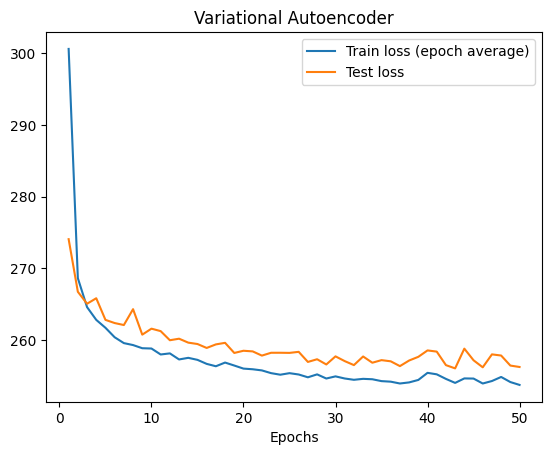

In [14]:
plt.plot(range(1,len(train_loss_history_VAE)+1), train_loss_history_VAE, label="Train loss (epoch average)")
plt.plot(range(1,len(train_loss_history_VAE)+1), test_loss_history_VAE, label="Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Variational Autoencoder")
plt.show()

## Plot functions

In [15]:
def plot_latent_space(model):
    model.eval()
    z_all = []
    y_all = []
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc='Encoding'):
            """
            COMPLETE AQUI!

            Projete os dados de treinamento.

            COMPLETE AQUI!
            """

            data = data.to(device)

            output = model(data, compute_loss=False)

            if isinstance(output, AEOutput):
                z = output.z_proj
            else:
                z = output.z_sample

            z_all.append(z.cpu().numpy())

            y_all.append(target.numpy())

    z_all = np.concatenate(z_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    plt.figure(figsize=(10, 10))
    plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=5)
    plt.xlim(-6,6)
    plt.ylim(-6,6)
    plt.colorbar()
    plt.title(f'Latent projection')
    plt.show()

def plot_random_samples(model):
    """
    COMPLETE AQUI!

    Gere 100 novas amostras na variável 'samples'

    COMPLETE AQUI!
    """

    with torch.no_grad():
        # Amostrar do prior N(0, I)
        z = torch.randn(100, model.latent_dim).to(device)

        samples = model.decode(z)

    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            ax[i, j].imshow(samples[i*10+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
    plt.show()

## Show plots

Autoencoder:


Encoding:   0%|          | 0/118 [00:00<?, ?it/s]

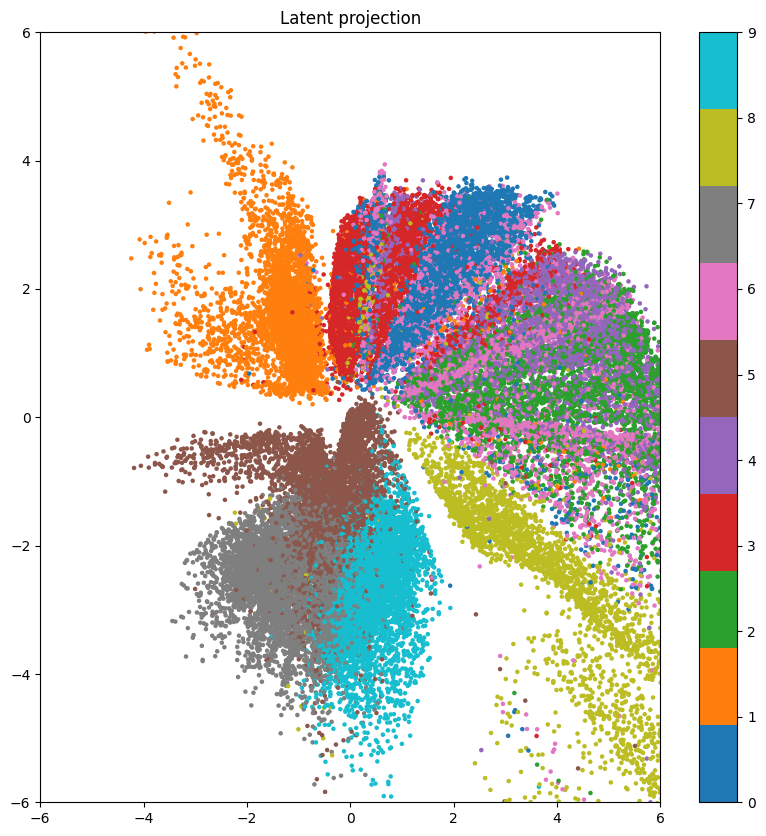

Variational Autoencoder:


Encoding:   0%|          | 0/118 [00:00<?, ?it/s]

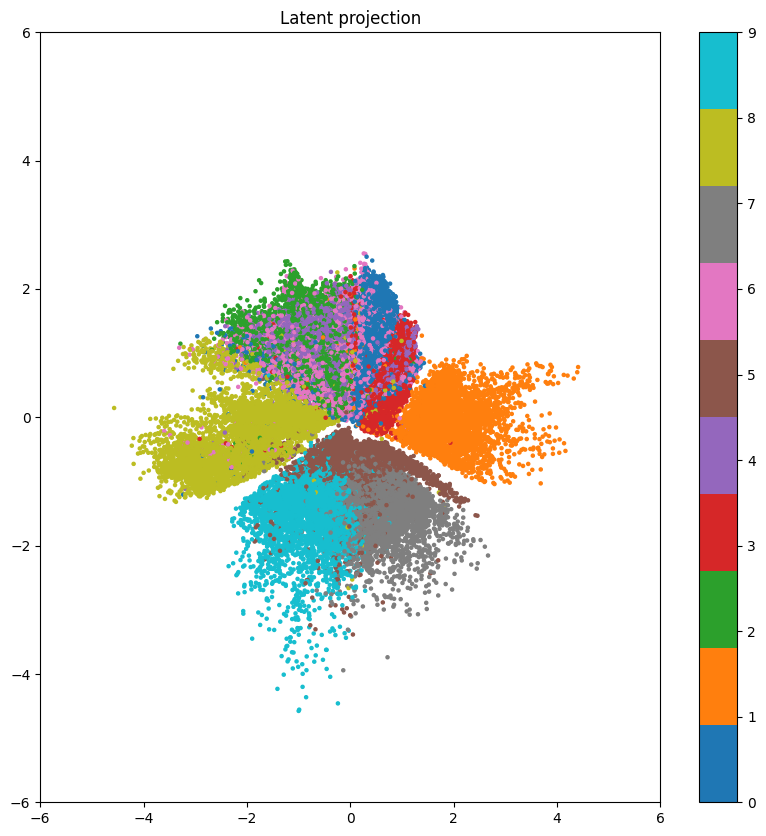

In [16]:
print("Autoencoder:")
plot_latent_space(model_AE)
print("Variational Autoencoder:")
plot_latent_space(model_VAE)

Autoencoder:


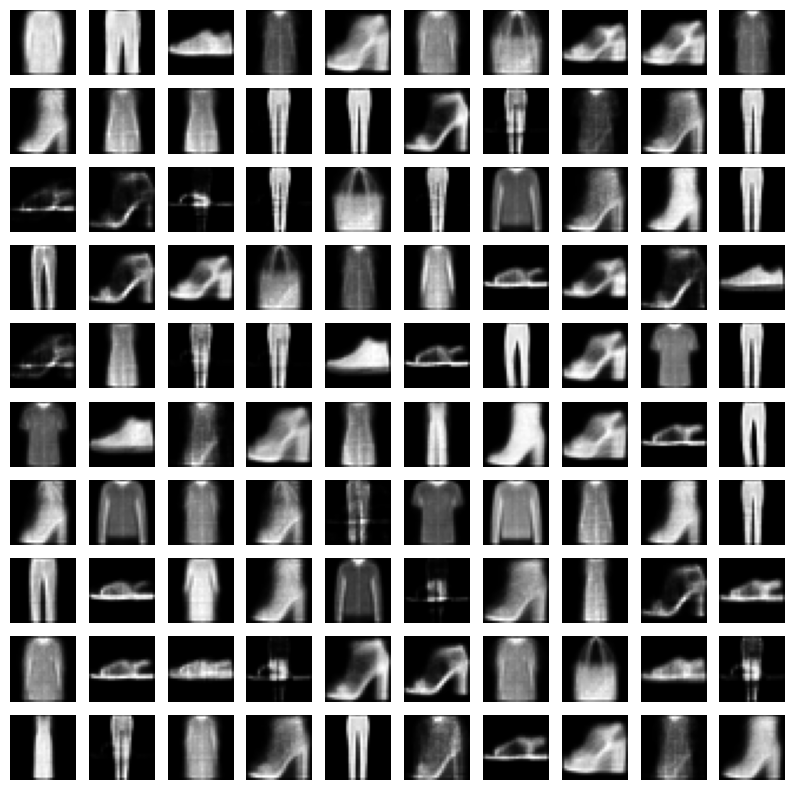

Variational Autoencoder:


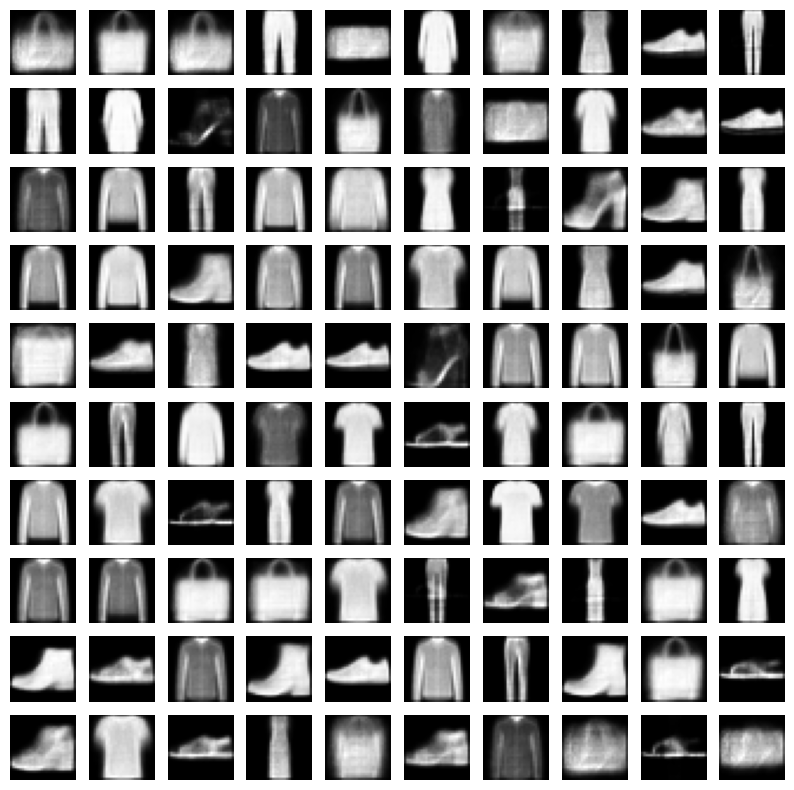

In [17]:
print("Autoencoder:")
plot_random_samples(model_AE)
print("Variational Autoencoder:")
plot_random_samples(model_VAE)

### Conclusão

Neste exercício, implementei e treinei um Autoencoder (AE) e um Variational Autoencoder (VAE) utilizando o dataset FashionMNIST, com o objetivo de comparar o comportamento de ambos os modelos em tarefas de aprendizado de representações latentes. O conjunto de teste foi utilizado apenas como validação, não participando do treinamento, conforme solicitado no enunciado.

A partir das curvas de perda, observa-se que ambos os modelos apresentaram convergência estável, com redução consistente da loss ao longo das épocas tanto no conjunto de treino quanto no de teste. O Autoencoder apresentou valores de perda menores em comparação ao VAE, o que já era esperado, uma vez que o AE otimiza apenas o erro de reconstrução, enquanto o VAE incorpora também o termo de regularização via divergência KL, tornando o problema de otimização mais restritivo.

Com esse experimento, foi possível compreender na prática as principais diferenças conceituais entre AE e VAE, bem como os impactos dessas diferenças no processo de treinamento, na função de perda e na geometria do espaço latente. O exercício reforçou a importância da regularização probabilística no VAE e mostrou como ela influencia tanto a performance quanto a interpretabilidade das representações aprendidas.